In [2]:
import pandas as pd
from ast import literal_eval
import sys
import csv
import struct
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
path_to_results = r'C:\Users\huda\Downloads\\'
#path_to_results = r'/home/dhu/Downloads/results/'

In [3]:
platform_c_maxint = 2 ** (struct.Struct('i').size * 8 - 1) - 1
csv.field_size_limit(platform_c_maxint)
#files = [r'C:\Users\huda\Downloads\results_ortools.txt', r'C:\Users\huda\Downloads\results_cplex_cp.txt', r'C:\Users\huda\Downloads\results_gurobi.txt', r'C:\Users\huda\Downloads\results_hexaly_rewritten.txt', r'C:\Users\huda\Downloads\results_cplex_lp_rewritten.txt']
files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
#files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly.txt', path_to_results +r'results_cplex_lp.txt']


In [4]:
from ast import literal_eval
import math
data = dict()
instances = []
for file in files:
    input_file = csv.DictReader(open(file), delimiter=';', fieldnames=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'])
    in_data = []
    for row in input_file:
        name = row['name'][:-12]
        if name.startswith('Error'):
            continue
        if name not in instances:
            instances.append(name)
        try:
            fitness = int(float(row['fitness_value'])+0.5)
            lb = int(float(row['lower_bound'])+0.5)
        except:
            fitness = float('inf')
            lb = float('inf')
        #fitness = int(float(row['fitness_value']) + 0.5) if row['fitness_value'] and row['fitness_value'].isnumeric() else float('inf')#int(float(row['fitness_value']) + 0.5)
        #lb = int(float(row['lower_bound']) + 0.5) if row['lower_bound'] and row['lower_bound'].isnumeric() else float('inf')#int(float(row['lower_bound']) + 0.5)
        if not math.isinf(lb) and not math.isinf(fitness):
            #progress_history = [r[2:] for r in row['best_result_history'].split('),')[1:]]#literal_eval(row['best_result_history'])
            #progress_history = [[float(x.split(',')[0]), int(float(x.split(',')[1][1:]) + 0.5), int(float(x.split(',')[2][1:])) if x.split(',')[2][1:].isnumeric() else int(float(x.split(',')[2][1:-2]))] for x in progress_history]
            try:
                progress_history = [[float(x.split(',')[0]), int(float(x.split(',')[1][1:]) + 0.5), int(float(x.split(',')[2][1:])) if x.split(',')[2][1:].isnumeric() else int(float(x.split(',')[2][1:-2]))] for x in [r[2:] for r in row['best_result_history'].split('),')[1:]]]
            except:
                continue
            
            #progress_history.append((float(row['runtime']), fitness, lb)) # in case callbacks didn't get triggered for the final result
            
            solver = file.split('\\')[-1][:-4]
            if solver == 'results_hexaly_rewritten':
                solver = 'results_hexaly'
            elif solver == 'results_cplex_lp_rewritten':
                solver = 'results_cplex_lp'
            solver = solver[8:]
            if solver not in data:
                data[solver] = dict()
            data[solver][name] = [fitness, lb, progress_history]
    

In [5]:
data.keys()

dict_keys(['ortools', 'cplex_cp', 'hexaly', 'cplex_lp'])

In [6]:
# fitness
max = False
col = 1
# lower bound
#max = True
#col = 2
def get_targets(instances, data, col : int = 1, max : bool = False):
    targets = dict()
    for instance in instances:
        best = -float('inf') if max else float('inf')
        if instance not in targets:
            targets[instance] = dict()
        for key in data.keys():
            if instance in data[key]:
                if (max and data[key][instance][col-1] > best) or (not max and data[key][instance][col-1] < best):
                    best = data[key][instance][col-1]
                targets[instance][key] = int(data[key][instance][col-1]+0.5)
        targets[instance]['overall'] = int(best+.05)
    return targets

In [7]:
targets_fitness = get_targets(instances, data, 1, False)
targets_lb = get_targets(instances, data, 2, True)

In [8]:
def get_timestamps(targets, col : int = 1, max : bool = False, max_diff : float = 0.1):
    #max_diff = 0.1
    results = dict()
    for instance in targets.keys():
        target_overall = targets[instance]['overall']
        if max:
            target_overall *= (1.0-max_diff)
        else:
            target_overall *= (1.0+max_diff)
        if instance not in results:
            results[instance] = dict()
        for solver in targets[instance].keys():
            if solver == 'overall':
                continue
            target_self = targets[instance][solver]
            if max:
                target_self *= (1.0-max_diff)
            else:
                target_self *= (1.0+max_diff)
            if solver not in results[instance]: # should never be in there?
                results[instance][solver] = dict()
            for entry in data[solver][instance][2]:
                if 'self' not in results[instance][solver] and ((max and entry[col] >= target_self) or (not max and entry[col] <= target_self)) and entry[col] > 0:
                    results[instance][solver]['self'] = entry[0] # timestamp
                if 'overall' not in results[instance][solver] and ((max and entry[col] >= target_overall) or (not max and entry[col] <= target_overall)) and entry[col] > 0:
                    results[instance][solver]['overall'] = entry[0]
            #if 'overall' not in results[instance][solver]:
            #    results[instance][solver]['overall'] = float('inf')
    return results

In [9]:
max_diff_fitness = 0.05
max_diff_lower_bounds = 0.05
results_fitness = get_timestamps(targets_fitness, max_diff=max_diff_fitness)
results_lower_bounds = get_timestamps(targets_lb, 2, True, max_diff=max_diff_lower_bounds)

In [10]:
plot_data_self_fitness = [[results_fitness[instance][key]['self'] for instance in results_fitness if key in results_fitness[instance] and 'self' in results_fitness[instance][key]] for key in data.keys()]
plot_data_overall_fitness = [[results_fitness[instance][key]['overall'] for instance in results_fitness if key in results_fitness[instance] and 'overall' in results_fitness[instance][key]] for key in data.keys()]
plot_data_self_lower_bounds = [[results_lower_bounds[instance][key]['self'] for instance in results_lower_bounds if key in results_lower_bounds[instance] and 'self' in results_lower_bounds[instance][key]] for key in data.keys()]
plot_data_overall_lower_bounds = [[results_lower_bounds[instance][key]['overall'] for instance in results_lower_bounds if key in results_lower_bounds[instance] and 'overall' in results_lower_bounds[instance][key]] for key in data.keys()]
labels = data.keys()

In [11]:
for l in plot_data_overall_fitness:
    l.sort()
for l in plot_data_self_fitness:
    l.sort()
for l in plot_data_self_lower_bounds:
    l.sort()
for l in plot_data_overall_lower_bounds:
    l.sort()


In [15]:
import matplotlib.pyplot as plt
def ecdf_inf(data, title, max : bool = False, n_instances : int = 402, labels : list[str] = [], instances : list[str] = [], markers : list = [], markerson : float = 0.1):
    plot_vectors = []
    for vector in data:
        plot_vectors.append([[0.0],[0.0]])
        i = 1
        while i < len(vector):
            if vector[i] == float('inf'):
                break
            if vector[i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0].append(vector[i-1])
            plot_vectors[-1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(data)):
        plt.plot(plot_vectors[i][0], plot_vectors[i][1], label=[labels[i]], marker=markers[i], markevery=markerson)
    plt.title(title)
    plt.legend()
    plt.show()


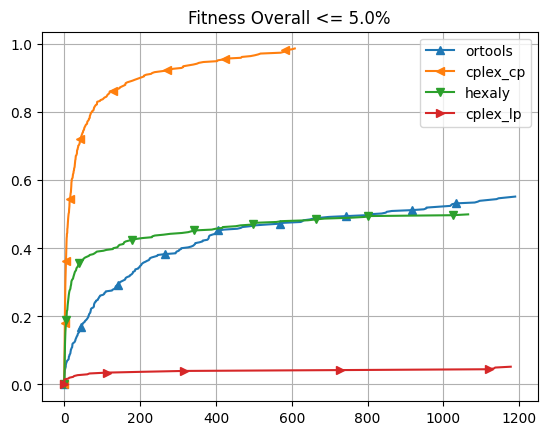

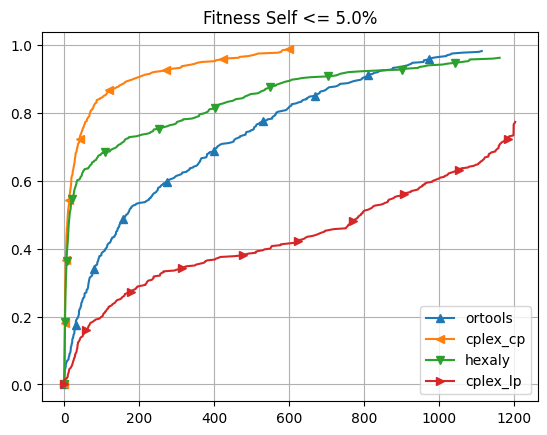

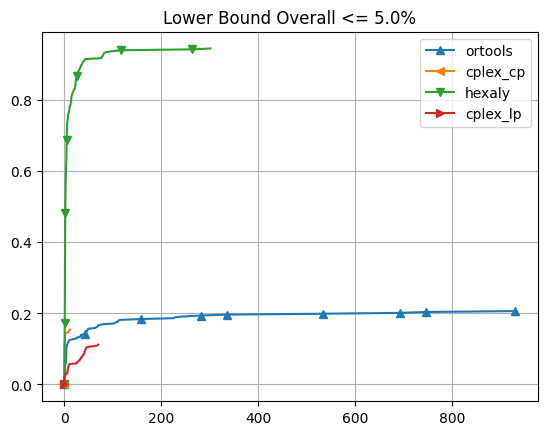

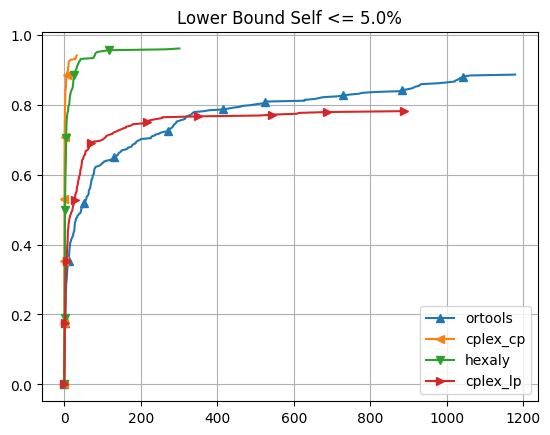

In [17]:
markers = ['^', '<', 'v', '>', 'x', '*', 'o']
markerson = 0.1
ecdf_inf(plot_data_overall_fitness, f'Fitness Overall <= {max_diff_fitness*100}%', labels=list(labels), markers=markers, markerson=markerson)
ecdf_inf(plot_data_self_fitness, f'Fitness Self <= {max_diff_fitness*100}%', labels=list(labels), markers=markers, markerson=markerson)
ecdf_inf(plot_data_overall_lower_bounds, f'Lower Bound Overall <= {max_diff_lower_bounds*100}%', labels=list(labels), markers=markers, markerson=markerson)
ecdf_inf(plot_data_self_lower_bounds, f'Lower Bound Self <= {max_diff_lower_bounds*100}%', labels=list(labels), markers=markers, markerson=markerson)